In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import keras.backend as K
import tensorflow as tf
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_dataset = train_datagen.flow_from_directory(directory='../data/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='training',
                                                  batch_size=64)

valid_dataset = valid_datagen.flow_from_directory(directory='../data/train',
                                                  target_size=(48,48),
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  batch_size=64)

test_dataset = test_datagen.flow_from_directory(directory='../data/test',
                                                target_size=(48,48),
                                                class_mode='categorical',
                                                batch_size=64)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),
                                            include_top=False,
                                            weights='imagenet')

94773248/94765736 [==============================] - 22s 0us/step


In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [11]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)               

In [13]:
#taken from old keras source code
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [14]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           f1_score]

In [15]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

In [17]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=60, verbose=1, callbacks=[lrd,mcp,es])

Epoch 1/60
359/359 [==============================] - 163s 454ms/step - loss: 2.0512 - accuracy: 0.8492 - precision: 0.1887 - recall: 0.0169 - auc: 0.5891 - f1_score: 0.0303 - val_loss: 2.3089 - val_accuracy: 0.8097 - val_precision: 0.1371 - val_recall: 0.0627 - val_auc: 0.5645 - val_f1_score: 0.0854 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - 160s 445ms/step - loss: 1.8732 - accuracy: 0.8559 - precision: 0.1661 - recall: 0.0022 - auc: 0.6207 - f1_score: 0.0043 - val_loss: 1.9037 - val_accuracy: 0.8570 - val_precision: 0.1429 - val_recall: 1.7419e-04 - val_auc: 0.5946 - val_f1_score: 3.4188e-04 - lr: 0.0010
Epoch 3/60
359/359 [==============================] - 159s 444ms/step - loss: 1.8316 - accuracy: 0.8570 - precision: 0.1892 - recall: 3.0477e-04 - auc: 0.6367 - f1_score: 5.9996e-04 - val_loss: 1.8586 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6165 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/60
359/359 [=======

359/359 [==============================] - 158s 440ms/step - loss: 1.7925 - accuracy: 0.8571 - precision: 0.4545 - recall: 2.1769e-04 - auc: 0.6622 - f1_score: 4.2854e-04 - val_loss: 1.8076 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6526 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 26/60
359/359 [==============================] - 161s 448ms/step - loss: 1.7928 - accuracy: 0.8571 - precision: 0.3333 - recall: 3.4831e-04 - auc: 0.6619 - f1_score: 6.8567e-04 - val_loss: 1.7946 - val_accuracy: 0.8571 - val_precision: 0.5000 - val_recall: 1.7419e-04 - val_auc: 0.6750 - val_f1_score: 3.4188e-04 - lr: 0.0010
Epoch 27/60
359/359 [==============================] - 159s 442ms/step - loss: 1.7914 - accuracy: 0.8571 - precision: 0.1875 - recall: 1.3062e-04 - auc: 0.6631 - f1_score: 2.5712e-04 - val_loss: 1.8539 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6300 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 28

Epoch 50/60
359/359 [==============================] - 156s 434ms/step - loss: 1.7846 - accuracy: 0.8571 - precision: 0.3889 - recall: 3.0477e-04 - auc: 0.6679 - f1_score: 5.9996e-04 - val_loss: 1.8071 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6584 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 51/60
359/359 [==============================] - 159s 444ms/step - loss: 1.7825 - accuracy: 0.8571 - precision: 0.3043 - recall: 3.0477e-04 - auc: 0.6709 - f1_score: 5.9996e-04 - val_loss: 1.8344 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6362 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 52/60
359/359 [==============================] - 159s 443ms/step - loss: 1.7835 - accuracy: 0.8571 - precision: 0.4286 - recall: 2.6123e-04 - auc: 0.6696 - f1_score: 5.1425e-04 - val_loss: 1.7975 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6629 - val_f1_score: 0.0000e+00 - lr:

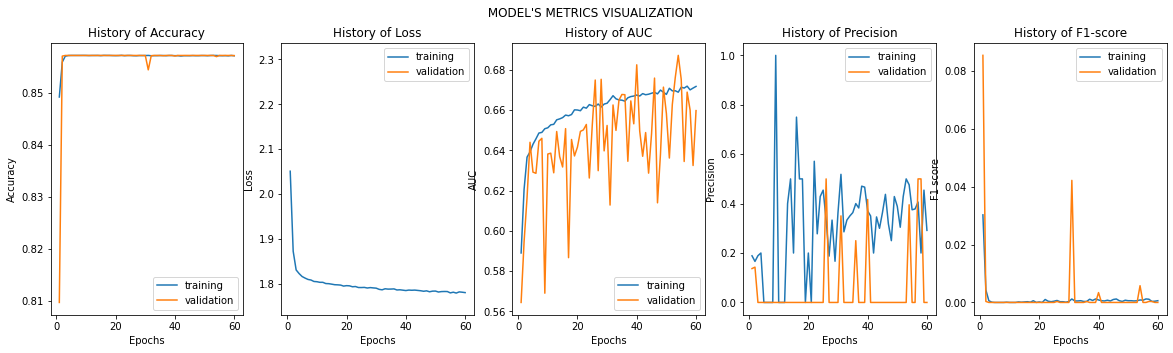

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'],
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']


fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()